In [1]:
#!pip install transformers

In [1]:
import pandas as pd
import numpy as np
import transformers
from transformers import BertPreTrainedModel, BertTokenizer, BertModel, BertConfig
import torch
from torch.utils.data import DataLoader,TensorDataset, RandomSampler, SequentialSampler

from tqdm import trange
from tqdm import tqdm_notebook as tqdm

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device(0)
torch.cuda.memory_allocated(device)

I1007 15:50:10.152489 139749386131200 file_utils.py:39] PyTorch version 1.1.0 available.
I1007 15:50:10.400380 139749386131200 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
I1007 15:50:10.577105 139749386131200 tokenization_utils.py:373] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/enlr/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


0

In [2]:
cls_id = tokenizer.convert_tokens_to_ids(tokenizer._cls_token)
sep_id = tokenizer.convert_tokens_to_ids(tokenizer._sep_token)


max_length = 512

def get_features_from_example(ex):
    input = ex.input.copy()
    pab = ex.pab_pos.copy()

    #add special tokens [CLS at beginning], [SEP at end], [optional SEP before pos]
    input = [cls_id]+input.tolist()+[sep_id]
    pab += 1
    
    #attention masking and padding
    mask = [1] * len(input)
    pad_length = max_length -len(input)
    #padding tokens and mask with 0
    input = input + [0]*pad_length
    mask = mask + [0]*pad_length

    assert len(input) == max_length
    assert len(mask) == max_length
    
    return input, mask, pab, int(ex.label)

In [3]:
def create_dataset(df):
    features = [get_features_from_example(df.iloc[i]) for i in range(len(df))]

    ids = torch.tensor([feature[0] for feature in features])
    masks = torch.tensor([feature[1] for feature in features])
    pabs = torch.tensor([feature[2] for feature in features])
    labels = torch.tensor([feature[3] for feature in features])

    print(ids.size(), masks.size(), pabs.size(), labels.size())

    return TensorDataset(ids, masks, pabs, labels)


## Cancat Model architecture

In [4]:
r"""
Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
    **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
        Classification (or regression if config.num_labels==1) loss.
    **logits**: ``torch.FloatTensor`` of shape ``(batch_size, config.num_labels)``
        Classification (or regression if config.num_labels==1) scores (before SoftMax).
    **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
        list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
        of shape ``(batch_size, sequence_length, hidden_size)``:
        Hidden-states of the model at the output of each layer plus the initial embedding outputs.
    **attentions**: (`optional`, returned when ``config.output_attentions=True``)
        list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
        Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.
"""
class BertForPronounResolutionConcat(BertPreTrainedModel):
    def __init__(self, config : BertConfig):
        super(BertForPronounResolutionConcat, self).__init__(config)
        
        self.bert = BertModel(config)
        
        #[P][A][B] classification layer
        self.classification = torch.nn.Linear(config.hidden_size * 3 , 3)
        
        self.init_weights()
    
    def forward(self, input_ids, attention_mask, pab, labels = None, token_type_ids = None ):
   
        #print(f'input shape = {input_ids.size()}')
        output = self.bert(input_ids, attention_mask, token_type_ids, None, None)
        last_hidden_states = output[0]
        
        batches = last_hidden_states.size()[0]
        row_indexes = torch.arange(batches).unsqueeze(1) # row numbers in a column matrix
        pab_hidden_states = last_hidden_states[row_indexes, pab] #batch size x 3 x hidden size
        
        concatenated_states = pab_hidden_states.view(batches,-1)
        
        #print(concatenated_states)
        logits = self.classification(concatenated_states)
        
        output = (logits,) + output[2:] #hidden states and attention if present
        
        if labels is not None:
            loss_fun = torch.nn.CrossEntropyLoss()
            loss = loss_fun(logits, labels)
            
            output = (loss,) + output
            
        return output

In [6]:
class BertForPronounResolutionMul(BertPreTrainedModel):
    def __init__(self, config : BertConfig):
        super(BertForPronounResolutionMul, self).__init__(config)
        
        self.bert = BertModel(config)  
        
        
        self.init_weights()
        
        #TODO: use a trainable tensor instead of CLS
        #self.trainable_tensor = torch.nn.
    
    def forward(self, input_ids, attention_mask, pab, labels = None, token_type_ids = None ):
   
        pabc = torch.cat(( pab, torch.zeros_like(pab[:,0:1])), dim =1)[:,[0,3,1,2]]
        
        #print(f'input shape = {input_ids.size()}')
        output = self.bert(input_ids, attention_mask, token_type_ids, None, None)
        last_hidden_states = output[0]
        
        batches = last_hidden_states.size()[0]
        row_indexes = torch.arange(batches).unsqueeze(1) # row numbers in a column matrix
        
        pab_hidden_states = last_hidden_states[row_indexes, pabc] #batch size x 4 x hidden size
        #print(pab_hidden_states)
        
        attentions = pab_hidden_states[:,1:] * pab_hidden_states[:,0:1]#batch size x 3 x hidden size
        
        #print(attentions)
        logits = torch.sum(attentions, dim = 2)#batch size x 3

        #print(logits)
        
        output = (logits,) + output[2:] #hidden states and attention if present
        
        if labels is not None:
            loss_fun = torch.nn.CrossEntropyLoss()
            loss = loss_fun(logits, labels)
            
            output = (loss,) + output
            
        return output

#m = BertForPronounResolutionMul.from_pretrained('bert-base-uncased')
# a = torch.randint(high = 100,size = (2,5))
# pab = torch.randint(low = 1, high = 5, size = (2,3))
# m(a,None,pab)


## Segment ID model architecture

In [17]:
class BertForPronounResolution_Segment(BertPreTrainedModel):
    def __init__(self, config : BertConfig):
        
        config.type_vocab_size = 4
        print(config)
        super(BertForPronounResolution_Segment, self).__init__(config)
        
        self.bert = BertModel(config)   
        
        self.classification = torch.nn.Linear(config.hidden_size , 3)
        
        self.init_weights()
        

    def get_token_type_ids(inp,p):
        tokentypes = torch.zeros_like(inp)
        tokentypes[p[0]]=1
        tokentypes[p[1]]=2
        tokentypes[p[2]]=3    
        return tokentypes
        
    def forward(self, input_ids, attention_mask, pab, labels = None, token_type_ids = None ):
   
        token_type_ids = torch.tensor([ get_token_type_ids(inp,p)  for inp,p in zip(input_ids, pab) ])
        
        print(f'token types = {token_type_ids}')
        
        output = self.bert(input_ids, attention_mask, token_type_ids, None, None)
        
        pooler_output = output[1]

        #print(attentions)
        logits = self.classification(pooler_output)
        torch.sum(attentions, dim = 2)#batch size x 3

        #print(logits)
        
        output = (logits,) + output[2:] #hidden states and attention if present
        
        if labels is not None:
            loss_fun = torch.nn.CrossEntropyLoss()
            loss = loss_fun(logits, labels)
            
            output = (loss,) + output
            
        return output

# m = BertForPronounResolution_Segment.from_pretrained('bert-base-uncased')
# a = torch.randint(high = 100,size = (2,5))
# pab = torch.randint(low = 1, high = 5, size = (2,3))
# m(a,None,pab)


## Create datasets

In [7]:
train_df =  pd.read_pickle('train_processed.pkl')
val_df =  pd.read_pickle('val_processed.pkl')

train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)

#test_data = train_dataset[0:2]
#test_data = (t.to(device) for t in test_data)
#%time model(*test_data)

torch.Size([2000, 512]) torch.Size([2000, 512]) torch.Size([2000, 3]) torch.Size([2000])
torch.Size([454, 512]) torch.Size([454, 512]) torch.Size([454, 3]) torch.Size([454])


### args

In [8]:
import argparse
args = argparse.Namespace(
    epochs = 3,
    lr = 2E-5,
    per_step_batch_size = 64,
    gradient_acc = 16
    )

batch_size = args.per_step_batch_size//args.gradient_acc
args.batch_size = batch_size


torch.cuda.memory_allocated(device)

0

## Train and evaluate

In [9]:
def evaluate(val_dataset,model):
    val_sampler = SequentialSampler(val_dataset)
    val_dataloader = DataLoader(val_dataset,batch_size= 64, sampler = val_sampler)

    all_labels = []
    all_preds = []
    total_loss = 0
    acc = 0
    model.eval()
    steps = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            labels = batch[-1]
            batch = tuple(t.to(device) for t in batch)
            loss,logits = model(*batch)
            preds = torch.argmax(logits, dim = 1)

            total_loss+=loss.item()
            all_labels.extend(labels.tolist())
            all_preds.extend(preds.tolist())
            steps += 1


    acc = np.sum(np.array(all_preds) == np.array(all_labels))/ len(all_preds)
    loss = total_loss/steps
    return loss,acc

In [10]:
import matplotlib.pyplot as plt

def train(train_dataset, val_dataset, model, args):
    
    optimizer = torch.optim.Adam(model.parameters(),lr = args.lr) #change it to AdamW later
    sampler = RandomSampler(train_dataset)
    dataloader = DataLoader(train_dataset,batch_size= args.batch_size, sampler = sampler)

    losses = []
    total_loss = 0
    

    
    for epoch in tqdm(range(args.epochs),position=1, total=args.epochs):
        
        model.train()
        batch_iterator = tqdm(dataloader, desc='batch_iterator')
        
        for step, batch in enumerate(batch_iterator):
            batch = (t.to(device) for t in batch)
            loss,logits = model(*batch)

            #print(f'step = {step}, loss = {losses[-1]}')

            loss = loss/args.gradient_acc
            loss.backward()

            total_loss+=loss.item()

            if (step+1) % args.gradient_acc == 0:
                optimizer.step()
                optimizer.zero_grad()
                losses.append(total_loss)
                batch_iterator.set_postfix({'loss':losses[-1]}, refresh=True)
                batch_iterator.write(f'step = {step}, loss = {total_loss}')
                total_loss=0
        val_loss , val_acc = evaluate(val_dataset, model)
        batch_iterator.write(f'Epoch = {epoch}, Val loss = {val_loss}, val_acc = {val_acc}')
        
    return losses

    

I1007 15:50:29.574311 139749386131200 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/enlr/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1007 15:50:29.575519 139749386131200 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1007 15:50:29.783313 139749386131200 modeli

439061504

# concat model

In [ ]:
model = BertForPronounResolution.from_pretrained('bert-base-uncased')
#model = BertForPronounResolutionMul.from_pretrained('bert-base-uncased')
model = model.to(device)
torch.cuda.memory_allocated(device)

step = 15, loss = 0.7916645500808954
step = 31, loss = 0.8542960379272699
step = 47, loss = 0.7391661424189806
step = 63, loss = 0.8919378258287907
step = 79, loss = 0.6966466996818781
step = 95, loss = 0.6980650341138244
step = 111, loss = 0.6372258681803942
step = 127, loss = 0.9714848287403584
step = 143, loss = 0.6788178961724043
step = 159, loss = 0.7591176014393568
step = 175, loss = 0.6106825340539217
step = 191, loss = 0.8301067799329758
step = 207, loss = 0.6880113892257214
step = 223, loss = 0.7641087900847197
step = 239, loss = 0.68553501740098
step = 255, loss = 0.7796583138406277
step = 271, loss = 0.7523402441293001
step = 287, loss = 0.7021260187029839
step = 303, loss = 0.6611818894743919
step = 319, loss = 0.7043791748583317
step = 335, loss = 0.8052687589079142
step = 351, loss = 0.738133005797863
step = 367, loss = 0.6436194004490972
step = 383, loss = 0.6682134866714478
step = 399, loss = 0.6792800165712833
step = 415, loss = 0.6080848537385464
step = 431, loss = 0.

Epoch = 0, Val loss = 0.49564917758107185, val_acc = 0.7929515418502202


step = 15, loss = 0.6228451933711767
step = 31, loss = 0.4655329929664731
step = 47, loss = 0.5008675018325448
step = 63, loss = 0.34701877273619175
step = 79, loss = 0.44370400719344616
step = 95, loss = 0.5771556589752436
step = 111, loss = 0.47939705196768045
step = 127, loss = 0.3433717451989651
step = 143, loss = 0.5675789136439562
step = 159, loss = 0.39136450085788965
step = 175, loss = 0.47145484015345573
step = 191, loss = 0.3569950070232153
step = 207, loss = 0.3976039830595255
step = 223, loss = 0.36215207166969776
step = 239, loss = 0.38615697249770164
step = 255, loss = 0.37201882246881723
step = 271, loss = 0.40857172943651676
step = 287, loss = 0.43873067665845156
step = 303, loss = 0.44335668347775936
step = 319, loss = 0.39296042639762163
step = 335, loss = 0.26948321517556906
step = 351, loss = 0.3930641310289502
step = 367, loss = 0.432115875184536
step = 383, loss = 0.42352257668972015
step = 399, loss = 0.2838566116988659
step = 415, loss = 0.38573249988257885
step

Epoch = 1, Val loss = 0.416640754789114, val_acc = 0.8325991189427313


step = 15, loss = 0.3458228353410959
step = 31, loss = 0.33714070823043585
step = 47, loss = 0.20951562002301216
step = 63, loss = 0.3329116925597191
step = 79, loss = 0.3702168669551611
step = 95, loss = 0.2774099875241518
step = 111, loss = 0.21796184964478016
step = 127, loss = 0.2852888163179159
step = 143, loss = 0.2067358186468482
step = 159, loss = 0.2641458287835121
step = 175, loss = 0.25581724662333727
step = 191, loss = 0.24645336624234915
step = 207, loss = 0.19164441525936127
step = 223, loss = 0.27024228125810623
step = 239, loss = 0.23963692225515842
step = 255, loss = 0.13564254716038704
step = 271, loss = 0.2846699636429548
step = 287, loss = 0.18161071464419365
step = 303, loss = 0.18326221499592066
step = 319, loss = 0.15270341653376818
step = 335, loss = 0.18352807871997356
step = 351, loss = 0.19014545902609825
step = 367, loss = 0.19209754839539528
step = 383, loss = 0.35177184641361237
step = 399, loss = 0.2523478362709284
step = 415, loss = 0.15428109280765057
s

Epoch = 2, Val loss = 0.33714463002979755, val_acc = 0.8590308370044053


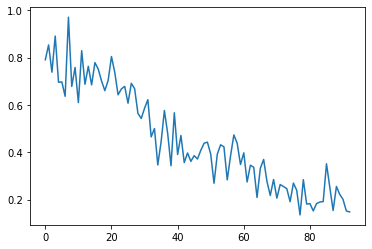

In [15]:
losses = train(train_dataset, val_dataset, model, args)
plt.plot(losses)

## Multiplication model

In [ ]:
#model = BertForPronounResolution.from_pretrained('bert-base-uncased')
model = BertForPronounResolutionMul.from_pretrained('bert-base-uncased')
model = model.to(device)
torch.cuda.memory_allocated(device)

step = 15, loss = 9.602057158946991
step = 31, loss = 5.8985395431518555
step = 47, loss = 6.245501458644867
step = 63, loss = 4.642662525177002
step = 79, loss = 3.8698235750198364
step = 95, loss = 4.022881209850311
step = 111, loss = 3.0187883973121643
step = 127, loss = 2.4068474769592285
step = 143, loss = 3.1808049082756042
step = 159, loss = 4.886632978916168
step = 175, loss = 2.4015565514564514
step = 191, loss = 2.5935561060905457
step = 207, loss = 3.23126083612442
step = 223, loss = 1.6209517121315002
step = 239, loss = 1.183289885520935
step = 255, loss = 1.7556816935539246
step = 271, loss = 0.7006791830062866
step = 287, loss = 1.4791873693466187
step = 303, loss = 0.6754513382911682
step = 319, loss = 1.0017993450164795
step = 335, loss = 0.848925769329071
step = 351, loss = 1.0498071908950806
step = 367, loss = 1.2652817964553833
step = 383, loss = 1.0171902179718018
step = 399, loss = 1.4061124920845032
step = 415, loss = 1.1766276359558105
step = 431, loss = 0.730969

Epoch = 0, Val loss = 0.768327996134758, val_acc = 0.7841409691629956


step = 15, loss = 0.22824722528457642
step = 31, loss = 0.2920791506767273
step = 47, loss = 0.613080620765686
step = 63, loss = 0.2873234152793884
step = 79, loss = 0.4530527591705322
step = 95, loss = 0.423633873462677
step = 111, loss = 0.5904667973518372
step = 127, loss = 0.3023343086242676
step = 143, loss = 0.34669268131256104
step = 159, loss = 0.5939683318138123
step = 175, loss = 0.42190420627593994
step = 191, loss = 0.5465742349624634
step = 207, loss = 0.3423260450363159
step = 223, loss = 0.40914386510849
step = 239, loss = 0.4017993211746216
step = 255, loss = 0.5142531394958496
step = 271, loss = 0.2859504222869873
step = 287, loss = 0.23487335443496704
step = 303, loss = 0.31894975900650024
step = 319, loss = 0.3466665744781494
step = 335, loss = 0.322227418422699
step = 351, loss = 0.40607964992523193
step = 367, loss = 0.44556599855422974
step = 383, loss = 0.33188897371292114
step = 399, loss = 0.5686752200126648
step = 415, loss = 0.5598810911178589
step = 431, los

Epoch = 1, Val loss = 0.65932247787714, val_acc = 0.7819383259911894


step = 15, loss = 0.3962147831916809
step = 31, loss = 0.3509036898612976
step = 47, loss = 0.225655198097229
step = 63, loss = 0.5309136509895325
step = 79, loss = 0.3235270380973816
step = 95, loss = 0.40063923597335815
step = 111, loss = 0.36100244522094727
step = 127, loss = 0.3395654559135437
step = 143, loss = 0.19231075048446655
step = 159, loss = 0.22550725936889648
step = 175, loss = 0.352172315120697
step = 191, loss = 0.27384793758392334
step = 207, loss = 0.2530386447906494
step = 223, loss = 0.3379824161529541
step = 239, loss = 0.46887052059173584
step = 255, loss = 0.26213711500167847
step = 271, loss = 0.23440998792648315
step = 287, loss = 0.24604129791259766
step = 303, loss = 0.21807140111923218
step = 319, loss = 0.2608690857887268
step = 335, loss = 0.22893309593200684
step = 351, loss = 0.20094460248947144
step = 367, loss = 0.29955703020095825
step = 383, loss = 0.34174615144729614
step = 399, loss = 0.16451328992843628
step = 415, loss = 0.2614430785179138
step 

Epoch = 2, Val loss = 0.5983525142073631, val_acc = 0.7929515418502202


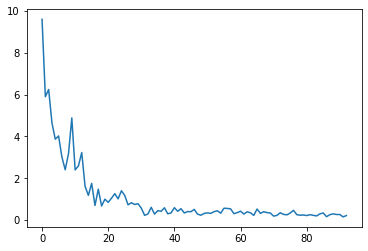

In [12]:
losses = train(train_dataset, val_dataset, model, args)
plt.plot(losses)